In [1]:
%reset

In [165]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torch.utils.data import Subset
import utils

In [166]:
import importlib
import utils, vae, evaluator 
importlib.reload(utils)
importlib.reload(vae)
importlib.reload(evaluator)

<module 'evaluator' from '/home/user/SNNE/MiniProject3/src/evaluator.py'>

## Load dataset

In [167]:
from utils import CustomDataset

In [127]:
DATA_PATH = "../data/trafic_32"
dataset = datasets.ImageFolder(root=DATA_PATH)
custom_dataset = CustomDataset(dataset, transform=transforms.ToTensor())

## Get dataset mean and std 

In [128]:
from torchvision import transforms
from utils import get_mean_std
batch_size = 32

loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers = 6, drop_last=True)
mean, std = get_mean_std(loader)

tensor([0.3185, 0.2930, 0.3016]) tensor([0.2735, 0.2629, 0.2661])


In [4]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=mean, std=std),
    ]
)
transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=mean, std=std),
    ]
)

## Split dataset

In [129]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(
    range(len(dataset)), [n_train_examples, n_val_examples]
)
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [130]:
batch_size = 256

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=6
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=6)

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

torch.Size([3, 1090, 274])


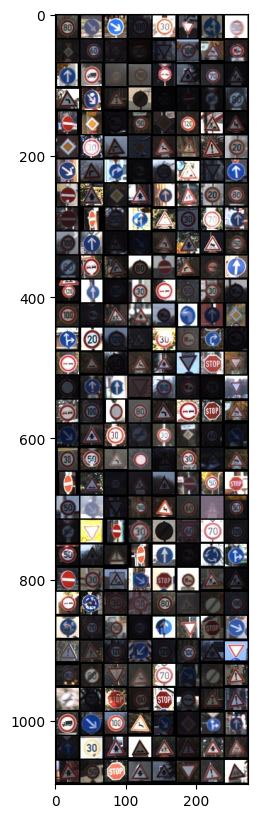

In [132]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))
def unnormalize(img):
    for channel in range(3):
        img[channel] = (img[channel] * std[channel]) + mean[channel]  # unnormalize
    return img

def imshow(img):
    print(img.shape)
    # img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

# VAE


In [169]:
importlib.reload(vae)
from vae import VAE, vae_loss_function

# VAE training

In [171]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3072).to(device)
vae

VAE(
  (encoder): Encoder(
    (fc_1): Linear(in_features=3072, out_features=1024, bias=True)
    (fc_2): Linear(in_features=1024, out_features=256, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
    (fc_mean): Linear(in_features=256, out_features=16, bias=True)
    (fc_var): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=16, out_features=256, bias=True)
    (fc_2): Linear(in_features=256, out_features=1024, bias=True)
    (fc_5): Linear(in_features=1024, out_features=3072, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [172]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [173]:
num_epochs = 40
losses_train = []
losses_val = []
for n in range(num_epochs):
    losses_epoch_train, losses_epoch_val = [], []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch_train.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for x, _ in iter(val_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch_val.append(loss.item())
    loss_val_mean = np.mean(losses_epoch_val)
    losses_val.append(loss_val_mean)
    loss_train_mean = np.mean(losses_epoch_train)
    losses_train.append(loss_train_mean)

    print(f"Epoch {n} loss train = {loss_train_mean}, loss val = {loss_val_mean}")
    scheduler.step()

Epoch 0 loss train = 35977.20102163462, loss val = 26393.573930584018
Epoch 1 loss train = 23142.76830786401, loss val = 20990.795370133197
Epoch 2 loss train = 19900.99847613324, loss val = 18850.09045210041
Epoch 3 loss train = 18301.69911143544, loss val = 17704.311603483606
Epoch 4 loss train = 17212.80967762706, loss val = 16620.604139984633
Epoch 5 loss train = 16459.968084649725, loss val = 16134.528880635246
Epoch 6 loss train = 16008.151785714286, loss val = 15678.411533043032
Epoch 7 loss train = 15519.347624055632, loss val = 15278.447425717213
Epoch 8 loss train = 15323.070087139424, loss val = 15272.205670466188
Epoch 9 loss train = 14918.946331988323, loss val = 14888.419665727459
Epoch 10 loss train = 14774.335304344093, loss val = 14925.842325179303
Epoch 11 loss train = 14580.174536401099, loss val = 14659.506019467213
Epoch 12 loss train = 14454.38883284684, loss val = 14519.199971183401
Epoch 13 loss train = 14261.446675394918, loss val = 14245.280945824796
Epoch 14 

Text(0, 0.5, 'Loss')

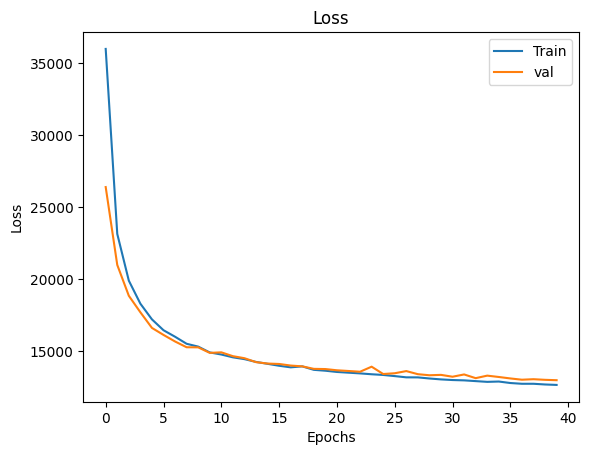

In [174]:
plt.plot(losses_train, label="Train")
plt.plot(losses_val, label="val")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Load model

In [17]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3072).to(device)
vae.load_state_dict(torch.load("../models/vae_new_with_norm.pth"))

<All keys matched successfully>

In [ ]:
losses_val = []
losses_epoch_val = []

for x, _ in iter(val_loader):
    x = x.to(device)
    out, means, log_var = vae(x)
    loss = vae_loss_function(x, out, means, log_var)
    losses_epoch_val.append(loss.item())
loss_val_mean = np.mean(losses_epoch_val)
losses_val.append(loss_val_mean)
print(f"loss val = {loss_val_mean}")



## Reconstructions

In [111]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(0, 0 + num)], dim=0)

In [149]:
from utils import visualize_reconstructions

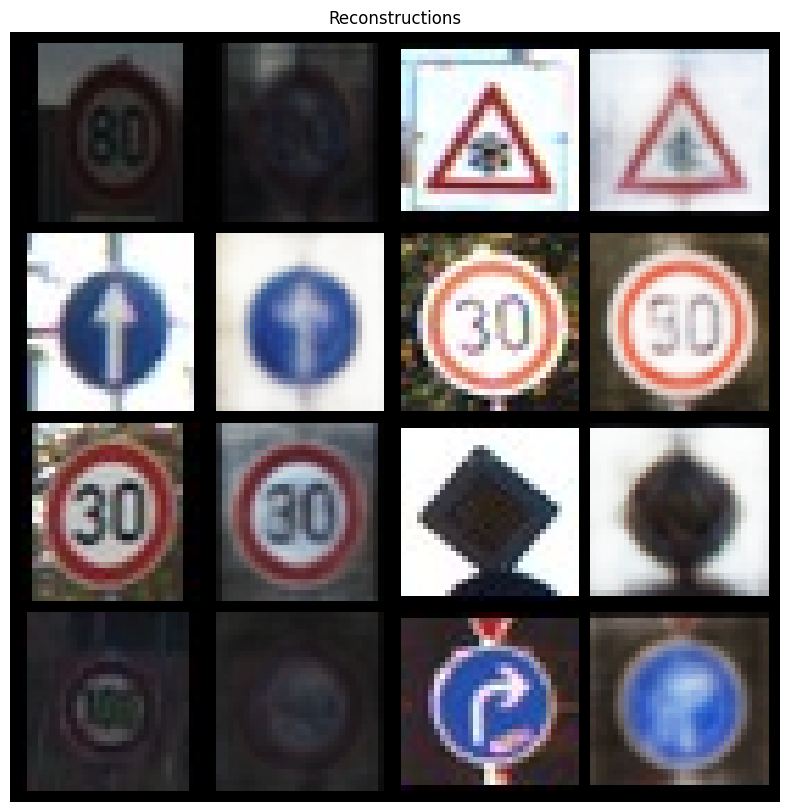

In [175]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)


## Generate images

In [25]:
def unnormalize(img):
    for channel in range(3):
        img[channel] = (img[channel] * std[channel]) + mean[channel]  # unnormalize
    return img


def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(
            torch.randn([n_imgs, model.latent_dim]).to(device)
        )
    generated_imgs = generated_imgs.cpu()
    generate_images = [img for img in generated_imgs]
    grid = torchvision.utils.make_grid(
        generated_imgs, nrow=4, normalize=False
    )
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

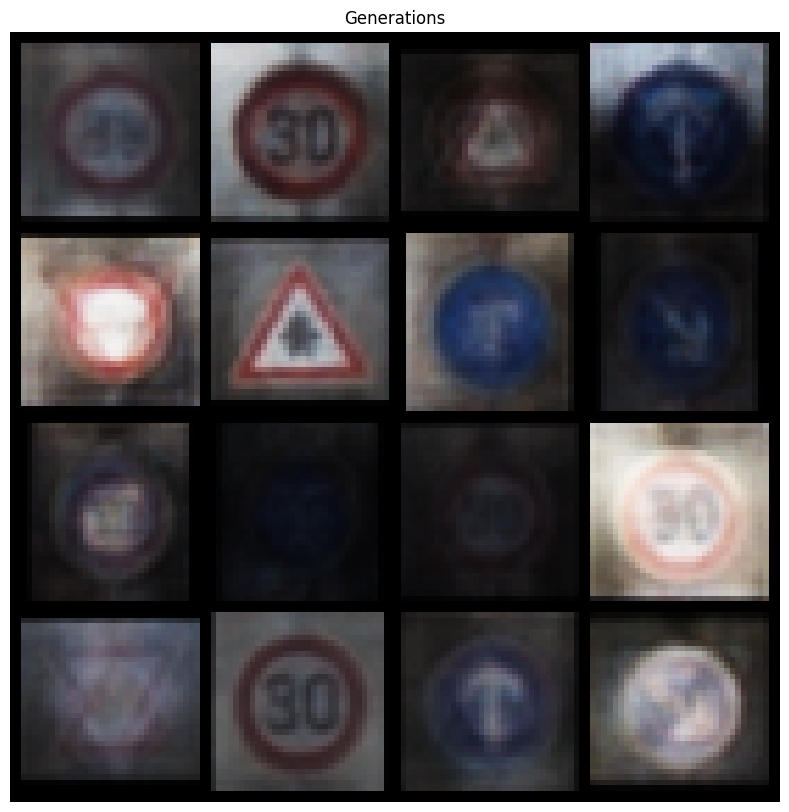

In [176]:
generate_images(vae, 16, device)

# Load evaluator

In [181]:
from evaluator import Evaluator
from utils import calculate_frechet_distance

In [182]:
evaluator = Evaluator(32 * 32 * 3, 256).to(device)
evaluator.load_state_dict(torch.load("../models/evaluator.pth"))

<All keys matched successfully>

## Eval generations

In [177]:
latent_dim = 16

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)
    print(generations_vae.shape)

torch.Size([1000, 3, 32, 32])


In [115]:
orig_data = [x[0] for x in list(val_dataset)[:1000]]
orig_data = torch.tensor(np.array(orig_data))

In [183]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [184]:
calculate_frechet_distance(dist_orig_data.numpy(),dist_vae.numpy())

5.127452403743504

In [155]:
orig_data_2 = [x[0] for x in list(val_dataset)[-1000:]]
orig_data_2 = torch.tensor(np.array(orig_data_2))
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [158]:
calculate_frechet_distance(dist_orig_data_2.numpy(),dist_vae.numpy())

5.211988175512587

In [160]:
calculate_frechet_distance(dist_orig_data.numpy(),dist_orig_data.numpy())


0.0

# Save model

In [161]:
path = "../models/simpler_net_no_norm_no_batch_norm.pth"
torch.save(vae.state_dict(), path)

# Save generations

In [163]:
torch.save(generations_vae.cpu().detach(),"../generations/poniedzialek_macuga_kutyla.pt")